In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [ ]:
latent_dim = 100
batch_size = 16 
epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(mnist, batch_size=batch_size, shuffle=True)

In [14]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 784),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), 1, 28, 28)
        return img

In [15]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)
        return validity

In [16]:
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)


In [17]:

adversarial_loss = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002)

In [18]:
for epoch in range(epochs):
    for i, (imgs, _) in enumerate(dataloader):
        real_imgs = imgs.to(device)
        batch_size = real_imgs.size(0)

        # Labels
        real = torch.ones(batch_size, 1).to(device)
        fake = torch.zeros(batch_size, 1).to(device)

        # Train Generator
        optimizer_G.zero_grad()
        z = torch.randn(batch_size, latent_dim).to(device)
        gen_imgs = generator(z)
        g_loss = adversarial_loss(discriminator(gen_imgs), real)
        g_loss.backward()
        optimizer_G.step()

        # Train Discriminator
        optimizer_D.zero_grad()
        real_loss = adversarial_loss(discriminator(real_imgs), real)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

    print(f"Epoch {epoch}/{epochs} | D Loss: {d_loss.item()} | G Loss: {g_loss.item()}")



Epoch 0/50 | D Loss: 0.14756734669208527 | G Loss: 2.4448959827423096
Epoch 1/50 | D Loss: 0.3201538324356079 | G Loss: 2.90340518951416
Epoch 2/50 | D Loss: 0.24842216074466705 | G Loss: 3.116610527038574
Epoch 3/50 | D Loss: 0.10871268808841705 | G Loss: 2.29579496383667
Epoch 4/50 | D Loss: 0.1701996624469757 | G Loss: 2.7274575233459473
Epoch 5/50 | D Loss: 0.5666412115097046 | G Loss: 1.0176899433135986
Epoch 6/50 | D Loss: 0.38415825366973877 | G Loss: 1.2321972846984863
Epoch 7/50 | D Loss: 0.384369432926178 | G Loss: 2.265965223312378
Epoch 8/50 | D Loss: 0.45919880270957947 | G Loss: 1.8178613185882568
Epoch 9/50 | D Loss: 0.4210612177848816 | G Loss: 1.8590108156204224
Epoch 10/50 | D Loss: 0.529327392578125 | G Loss: 0.7689390182495117
Epoch 11/50 | D Loss: 0.503126323223114 | G Loss: 1.5735892057418823
Epoch 12/50 | D Loss: 0.5579376220703125 | G Loss: 1.4886122941970825
Epoch 13/50 | D Loss: 0.4368644654750824 | G Loss: 1.4453539848327637
Epoch 14/50 | D Loss: 0.5895986557

In [19]:
z = torch.randn(16, latent_dim).to(device)
generated_imgs = generator(z).detach().cpu()

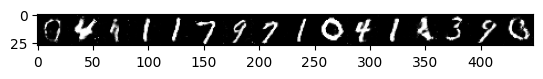

In [20]:
import matplotlib.pyplot as plt
grid_img = torch.cat([img for img in generated_imgs], dim=2).squeeze()
plt.imshow(grid_img.numpy(), cmap='gray')
plt.show()